# 50.040 Natural Language Processing (Fall 2024) Final Project (100 Points)

**DUE DATE: 13 December 2024**

Final project will be graded by Chen Huang


# Group Information (Fill before you start)

**Group Name:** Perplexity

**Name(STUDNET ID) (2-3 person):**  
Jordan Lee Wei 1005906
Shwetha Iyer 1006308
Anutham Mukunthan 1006202

**Please also rename the final submitted pdf as ``finalproject_[GROUP_NAME].pdf``**

**-1 points if info not filled or file name not adjusted before submission, -100 points if you copy other's answer. We encourage discussion, but please do not copy without thinking.**

## [!] Please read this if your computer does not have GPUs.
### Free GPU Resources
We suggest that you run neural language models on machines with GPU(s). Google provides the free online platform [Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb), a research tool for machine learning education and research. It’s a Jupyter notebook environment that requires no setup to use as common packages have been  pre-installed. Google users can have access to a Tesla T4 GPU (approximately 15G memory). Note that when you connect to a GPU-based VM runtime, you are given a maximum of 12 hours at a time on the VM.

Colab is web-based, fast and convinient. You can simply upload this notebook and run it online. For the database needed in this task, you can download it and upload to colab OR you can save it in your google drive and link it with the colab.

It is convenient to upload local Jupyter Notebook files and data to Colab, please refer to the [tutorial](https://colab.research.google.com/notebooks/io.ipynb).

In addition, Microsoft also provides the online platform [Azure Notebooks](https://notebooks.azure.com/help/introduction) for research of data science and machine learning, there are free trials for new users with credits.

# Instructions
Please read the following instructions carefully before you begin this project:

- This is a group project. You are allowed to form groups in any way you like, but each group must consist of either 2 or 3 people. Please submit your group information to eDimension as soon as possible if you have not yet done so (the deadline was 11th October 2024).

- Each group should submit code along with a report summarizing your work, and provide clear instructions on how to run your code. Additionally, please submit your system's outputs. The output should be in the same column format as the training set.

- You are given **8** weeks to work on the project. We understand this is a busy time during your final term, so Week **13** will be reserved as the "Final Project Week" for you to focus on the project (i.e., there will be no classes that week). Please plan and manage your time well.

- Please use Python to complete this project.

# Project Summary
Welcome to the design project for our natural language processing (NLP) course offered at SUTD!

In this project, you will undertake an NLP task in _sentiment analysis_. We will begin by guiding you through data understanding, pre-processing, and instructing you to construct RNN and CNN models for the task. Afterward, you are encouraged to develop your own model to improve the results. The final test set will be released on **11 December 2024 at 5pm** (48 hours before the final project deadline). You will use your own system to generate the outputs. The system with the highest F1 score will be announced as the winner for each challenge. If no clear winner emerges from the test set results, further analysis or evaluations may be conducted.

# Task Introduction and Data pre-processing (20 points)
## Sentiment Analysis
With the proliferation of online social media and review platforms, vast amounts of opinionated data have been generated, offering immense potential to support decision-making processes. Sentiment analysis examines people's sentiments expressed in text, such as product reviews, blog comments, and forum discussions. It finds wide applications in diverse fields, including politics (e.g., analyzing public sentiment towards policies), finance (e.g., evaluating market sentiments), and marketing (e.g., product research and brand management).

Since sentiments can often be categorized into discrete polarities or scales (e.g., positive or negative), sentiment analysis can be framed as a text classification task. This task involves transforming text sequences of varying lengths into fixed-length categorical labels.

## Data pre-processing
In this project, we will utilize [Stanford's large movie review dataset](https://ai.stanford.edu/%7Eamaas/data/sentiment/) for sentiment analysis. The dataset consists of a training set and a testing set, each containing 25,000 movie reviews sourced from IMDb. Both datasets have an equal number of "positive" and "negative" labels, representing different sentiment polarities. Please download and extract this IMDb review dataset in the path `../data/aclImdb`.

*Hints*: While the following instructions are based on a split of 25,000 for training and 25,000 for testing, you are free to choose your own dataset split, as we will provide a separate test set for the final evaluation. However, any changes you make to the default split must be clearly indicated in your report. Failure to explicitly mention such modifications may result in a penalty.



In [1]:

import os
import torch
from torch import nn
#!pip install d2l
from d2l import torch as d2l # You can skip this if you have trouble with this package, all d2l-related codes can be replaced by torch functions.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Skip this if you have already downloaded the dataset
d2l.DATA_HUB['aclImdb'] = (d2l.DATA_URL + 'aclImdb_v1.tar.gz',
                          '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

# Questions

### Question 1 [code] **(5 points)**
Complete the function ``read_imdb``, which reads the IMDb review dataset text sequences and labels. Then, run the sanity check cell to check your implementation.

In [4]:
#@save
def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data = []
    labels = []
    folder = 'train' if is_train else 'test'
    for label in ['pos', 'neg']:
        labeled_folder = os.path.join(data_dir, folder, label)
        for filename in os.listdir(labeled_folder):
            if filename.endswith('.txt'):
                with open(os.path.join(labeled_folder, filename), 'r', encoding='utf-8') as f:
                    review = f.read()
                    data.append(review)
                    labels.append(1 if label == 'pos' else 0)
    return data, labels


In [5]:
# Sanity check
train_data = read_imdb(data_dir, is_train=True)

print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[:60])

# trainings: 25000
label: 1 review: Since was only a toddler when this show originally aired I j
label: 1 review: When you see this movie you begin to realise what a drastica
label: 1 review: I didn't know what to except so I think it was a lot better 


### Question 2 [code] **(5 points)**
Treating each word as a token and filtering out words that appear less than 5 times, we create a vocabulary out of the training dataset. After tokenization, please plot the histogram of review lengths in tokens. (Hint: you can use ``matplotlib`` package to draw the histogram.) Then, run the sanity check cell to check your implementation.

In [6]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

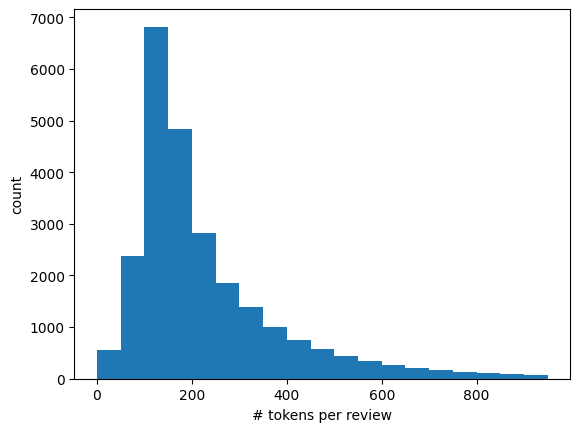

In [7]:
# xlabel: # tokens per review
# ylabel: count
import matplotlib.pyplot as plt

review_lengths = [len(tokens) for tokens in train_tokens]
plt.hist(review_lengths, bins=range(0, 1000, 50))
plt.xlabel('# tokens per review')
plt.ylabel('count')
plt.show()

In [8]:
num_steps = 500  # sequence length
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


### Question 3 [code] **(5 points)**
Create data iterator ``train_iter``, at each iteration, a minibatch of examples are returned. Let's set the mini-batch size to 64.



In [9]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64
train_set = TensorDataset(train_features, torch.tensor(train_data[1]))
train_iter = DataLoader(train_set, batch_size=batch_size, shuffle=True)


for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


### Question 4 [code] **(5 points)**
Finally, wrap up the above steps into the ``load_data_imdb`` function. It returns training and test data iterators and the vocabulary of the IMDb review dataset.


In [10]:
#@save
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    data_dir = '../data/aclImdb'
    train_data = read_imdb(data_dir, is_train=True)
    test_data = read_imdb(data_dir, is_train=False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = DataLoader(TensorDataset(train_features, torch.tensor(train_data[1])), batch_size=batch_size, shuffle=True)
    test_iter = DataLoader(TensorDataset(test_features, torch.tensor(test_data[1])), batch_size=batch_size)
    return train_iter, test_iter, vocab

# Using RNN for sentiment analysis (30 points)
Similar to word similarity and analogy tasks, pre-trained word vectors can also be applied to sentiment analysis. Given that the IMDb review dataset is relatively small, using text representations pre-trained on large-scale corpora can help mitigate model overfitting. Each token can be represented using the pre-trained GloVe model, and these token embeddings can be fed into a multilayer bidirectional RNN to generate a sequence representation of the text, which will then be transformed into sentiment analysis outputs. Later, we will explore an alternative architectural approach for the same downstream task.

### Question 5 [code] **(10 points)**
In text classification tasks, such as sentiment analysis, a varying-length text sequence is transformed into fixed-length categorical labels. Following the instructions, please complete ``BiRNN`` class, each token in a text sequence receives its individual pre-trained GloVe representation through the embedding layer (``self.embedding``). The entire sequence is then encoded by a bidirectional RNN (``self.encoder``). Specifically, the hidden states from the last layer of the bidirectional LSTM, at both the initial and final time steps, are concatenated to form the representation of the text sequence. This representation is subsequently passed through a fully connected layer (``self.decoder``) to produce the final output categories, which in this case are "positive" and "negative".

In [11]:
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

In [12]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)

        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)

        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)

        ### YOUR CODE HERE
        embeddings=self.embedding(inputs)
        embeddings=embeddings.permute(1,0,2)
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        ### END OF YOUR CODE

        return outs

Let’s construct a bidirectional RNN with two hidden layers to represent single text for sentiment analysis.

In [13]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
net.apply(init_weights)

BiRNN(
  (embedding): Embedding(49347, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

### Loading Pretrained Word Vectors

In [14]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape # Print the shape of the vectors for all the tokens in the vocabulary.

torch.Size([49347, 100])

We use these pretrained word vectors to represent tokens in the reviews and will not update these vectors during training

In [15]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

### Question 6 [code] **(10 points)**
After loading the pretrained word vectors, we can now start to train the model. Please use ``Adam`` optimizer and ``CrossEntropyLoss`` for training and draw a graph about your training loss, training acc and testing acc.

Epoch: 1, Training Loss: 0.5435
Epoch: 2, Training Loss: 0.3977
Epoch: 3, Training Loss: 0.3723
Epoch: 4, Training Loss: 0.3405
Epoch: 5, Training Loss: 0.3168


Text(0, 0.5, 'Train_loss')

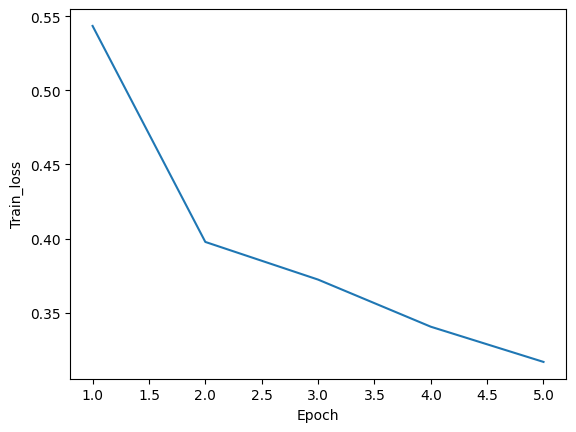

In [16]:
lr, num_epochs = 0.01, 5
### YOUR CODE HERE
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
loss_array=[]
for n in range(num_epochs):
        train_loss = 0
        target_num = 0
        net.train()
        for batch_idx, (data, target) in enumerate(train_iter):
            data, target = data.to(device), target.to(device)
            loss = None
            prediction= net(data)
            loss = criterion(prediction,target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * target.size(0)
            target_num += target.size(0)

        train_loss /= target_num
        loss_array.append(train_loss)
        print('Epoch: {}, Training Loss: {:.4f}'.format(n+1, train_loss))

plt.plot([i+1 for i in range(num_epochs)],loss_array)
plt.xlabel("Epoch")
plt.ylabel("Train_loss")
### END OF YOUR CODE

### Question 7 [code] **(10 points)**
Once you have completed the training, it's time to evaluate your model's performance. Implement the function ``predict_sentiment`` to predict the sentiment of a text sequence using the trained model ``net``. Next, define the function ``cal_metrics`` to assess your model on the test set by calculating both accuracy and the F1-score, including precision and recall. Finally, print out the evaluation results. Save the prediction results for each test sample and submit it in the zip file.

In [17]:
#@save
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    ### YOUR CODE HERE
    indices = [vocab[i] for i in sequence.split()]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
      prediction=net(torch.tensor(indices).unsqueeze(0).to(device))
    label = torch.argmax(prediction, dim=1).item()
    ### END OF YOUR CODE
    return 'positive' if label == 1 else 'negative'

In [18]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [19]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

In [44]:
def cal_metrics(net, test_iter, vocab):
    """Outputs a CSV file 'prediction_results.csv'
    with columns: review,gold_label,predicted_label.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()
    results = []

    tp, tn, fp, fn = 0, 0, 0, 0
    pad_idx = vocab['<pad>']

    for batch_idx, (data, target) in enumerate(test_iter):
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            prediction = net(data)
        label = torch.argmax(prediction, dim=1)
        data_cpu = data.cpu().numpy()
        for i in range(len(data_cpu)):
            tokens = [vocab.idx_to_token[idx] for idx in data_cpu[i] if idx != pad_idx]
            review_text = " ".join(tokens)
            gold_label = int(target[i].item())
            pred_label = int(label[i].item())
            results.append((review_text, gold_label, pred_label))

        tp += ((label == 1) & (target == 1)).sum().item()
        tn += ((label == 0) & (target == 0)).sum().item()
        fp += ((label == 1) & (target == 0)).sum().item()
        fn += ((label == 0) & (target == 1)).sum().item()

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp) if (tp+fp) > 0 else 0
    recall = tp/(tp+fn) if (tp+fn) > 0 else 0
    F1_Score = 2*(precision*recall)/(precision+recall) if (precision+recall) > 0 else 0

    import csv
    with open('prediction_results.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["review", "gold_label", "predicted_label"])
        for review_text, gold_label, pred_label in results:
            writer.writerow([review_text, gold_label, pred_label])

    return F1_Score, precision, recall, accuracy


In [24]:
cal_metrics(net, test_iter, vocab)

(0.837059094912553, 0.8797496253195803, 0.79832, 0.8446)

# Using CNN for sentiment analysis (20 points)
Although CNNs were originally designed for computer vision, they have been widely adopted in natural language processing as well. Conceptually, a text sequence can be viewed as a one-dimensional image, allowing one-dimensional CNNs to capture local features, such as n-grams, within the text. We will use the textCNN model to demonstrate how to design a CNN architecture for representing a single text.

Using one-dimensional convolution and max-over-time pooling, the textCNN model takes individual pre-trained token representations as input, then extracts and transforms these sequence representations for downstream tasks.

For a single text sequence with $n$ tokens represented by $d$-dimensional vectors, the width, height, and number of channels of the input tensor are $n$, $1$, and $d$, respectively. The textCNN model processes the input as follows:

1. Define multiple one-dimensional convolutional kernels and apply convolution operations on the inputs. Convolution kernels with varying widths capture local features across different numbers of adjacent tokens.
2. Apply max-over-time pooling to all output channels, then concatenate the resulting scalar outputs into a vector.
3. Pass the concatenated vector through a fully connected layer to generate the output categories. Dropout can be applied to reduce overfitting.

### Question 8 [code] **(10 points)**
Implement the ``textCNN`` model class. Compared with the bidirectional RNN model in Section 2, besides replacing recurrent layers with convolutional layers, we also use two embedding layers: one with trainable weights and the other with fixed weights.

In [25]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [26]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors

        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels

        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels

        ### YOUR CODE HERE
        emb1=self.embedding(inputs)
        emb2=self.constant_embedding(inputs)
        conc_emb=torch.cat((emb1, emb2), dim=-1)
        conc_emb = conc_emb.permute(0, 2, 1)
        conv_pooled_outputs = []
        for conv in self.convs:
            conv_out = conv(conc_emb)
            pooled = torch.max(conv_out, dim=2, keepdim=True)[0]
            conv_pooled_outputs.append(pooled)
        outputs = torch.cat(conv_pooled_outputs, dim=1)
        outputs = outputs.squeeze(-1)
        ### END OF YOUR CODE

        return outputs

In [27]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights)

TextCNN(
  (embedding): Embedding(49346, 100)
  (constant_embedding): Embedding(49346, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
)

In [28]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

### Question 9 [code] **(10 points)**
Similar to what we have done in Section 2 with RNN, train the CNN model with the same optimizer and loss function. Draw a graph about your training loss, training acc and testing acc. Use the prediction function you defined in Question 7 to evaluate your model performance.

Epoch: 1, Training Loss: 0.8757
Epoch: 2, Training Loss: 0.6762
Epoch: 3, Training Loss: 0.6368
Epoch: 4, Training Loss: 0.5954
Epoch: 5, Training Loss: 0.5585


Text(0, 0.5, 'Train_loss')

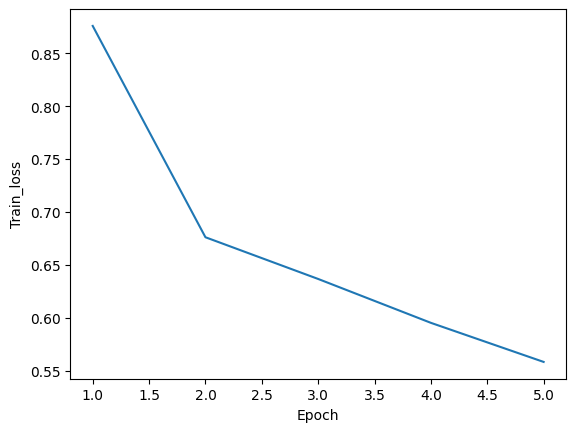

In [29]:
lr, num_epochs = 0.001, 5
### YOUR CODE HERE
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
loss_array=[]
for n in range(num_epochs):
        train_loss = 0
        target_num = 0
        net.train()
        for batch_idx, (data, target) in enumerate(train_iter):
            data, target = data.to(device), target.to(device)
            loss = None
            prediction= net(data)
            loss = criterion(prediction,target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * target.size(0)
            target_num += target.size(0)

        train_loss /= target_num
        loss_array.append(train_loss)
        print('Epoch: {}, Training Loss: {:.4f}'.format(n+1, train_loss))

plt.plot([i+1 for i in range(num_epochs)],loss_array)
plt.xlabel("Epoch")
plt.ylabel("Train_loss")
### END OF YOUR CODE

In [30]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [31]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

In [32]:
cal_metrics(net, test_iter, vocab)

(0.7124951037994517, 0.6980046047582502, 0.7276, 0.7064)

# Design Challenge (30 points)
Now it's time to come up with your own model! You are free to decide what model you want to choose or what architecture you think is better for this task. You are also free to set all the hyperparameter for training (do consider the overfitting issue and the computing cost). From here we will see how important choosing/designing a better model architecture could be when building an NLP application in practice (however, there is no requirement for you to include such comparisons in your report).

You are allowed to use external packages for this challenge, but we require that you fully understand the methods/techniques that you used, and you need to clearly explain such details in the submitted report. We will evaluate your system's performance on the held-out test set, which will only be released 48 hours before the deadline. Use your new system to generate the outputs. The system that achieves the highest F1 score will be announced as the winner for the challenge. We may perform further analysis/evaluations in case there is no clear winner based on the released test set.

Let's summarize this challenge:

(i) **[Model]** You are required to develop your own model for sentiment analysis, with no restrictions on the model architecture. You may choose to follow RNN/CNN structures or experiment with Transformer-based models. In your submitted report, you must provide a detailed explanation of your model along with the accompanying code. Additionally, you are required to submit your model so that we can reproduce your results.

*_(10 points)_*

(ii) **[Evaluation]** For a fair comparison, you must train your new model on the same dataset provided to you. After training, evaluate your model on the test set. You are required to report the **precision**, **recall**, **F1 scores**, and **accuracy** of your new model. Save the predicted outcome for the test set and include it in the submission.

_Hint:_ You will be competing with other groups on the same test set. Groups with higher performance will receive more points. For instance, if your group ranks 1st among all groups, you will receive 15 points for this section.

*_(15 points)_*

(iii) **[Report]** You are required to submit a report for your model. The report must include, at a minimum, the following sections: Model Description, Training Settings (e.g., dataset, hyperparameters), Performance, Code to run the model, and a breakdown of how the work was divided among team members. You are encouraged to include any additional details you deem important. Instructions on how to run the code can either be included in a separate README file or integrated into the report, as long as they are clearly presented.

Please provide a thorough explanation of the model or method you used for designing the new system, along with clear documentation on how to execute the code. We will review your code, and may request an interview if we have any questions about it.

_Note:_ Reports, code, and README files that are of low quality or poorly written will be penalized, so please ensure they are well-organized and clearly formatted. If we are unable to reproduce your model or run your code, you will not receive any points for this challenge.

*_(5 points)_*

# Start your model in a different .py file with a README explaination.